The following cell contains common imports and definitions. Run it first.

In [149]:
import matplotlib.pyplot as plt
import tikzplotlib
import pickle
import json
import numpy as np

ALGORITHMS = {
    'random': 'Random',
    'tribler': 'Tribler',
    'dinx_s': 'DINX (s)',
    'dinx': 'DINX',
    'panache': 'Panaché',
    'maay': 'MAAY',
    'grank': 'G-Rank',
    'ltr': 'DART'
}

def tikzplotlib_fix_ncols(obj):
    """Workaround function to fix legend column issue before saving with tikzplotlib."""
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    if hasattr(obj, 'gcf'):
        fig = obj.gcf()
        for ax in fig.get_axes():
            if hasattr(ax, 'legend_') and ax.legend_ is not None:
                if hasattr(ax.legend_, "_ncols"):
                    ax.legend_._ncol = ax.legend_._ncols
    else:
        for child in obj.get_children():
            tikzplotlib_fix_ncols(child)

# Dataset Analysis

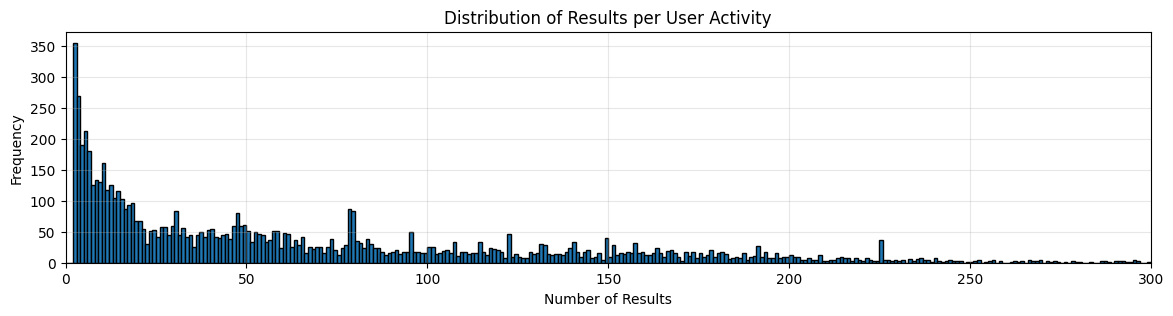

Number of activities with only one result: 814
Percentage of activities with only one result: 10.59%
Mean number of results per activity: 65.34
Median number of results per activity: 43.00


In [114]:
# Plot distribution of results per user activity
plt.figure(figsize=(14, 3))

with open('user_activities.pkl', 'rb') as f:
    user_activities = pickle.load(f)

result_counts = [len(ua.results) for ua in user_activities]

xmax = 300
plt.hist(result_counts, bins=range(xmax+1), edgecolor='black')
plt.xlabel('Number of Results')
plt.ylabel('Frequency') 
plt.title('Distribution of Results per User Activity')
plt.grid(True, alpha=0.3)
plt.xlim(0, xmax)
plt.show()

# Count activities with only one result
single_result_count = sum(1 for ua in user_activities if len(ua.results) < 5)
print(f"Number of activities with only one result: {single_result_count}")
print(f"Percentage of activities with only one result: {single_result_count/len(user_activities)*100:.2f}%")
# Calculate and print mean and median of result counts
mean_results = np.mean(result_counts)
median_results = np.median(result_counts)
print(f"Mean number of results per activity: {mean_results:.2f}")
print(f"Median number of results per activity: {median_results:.2f}")

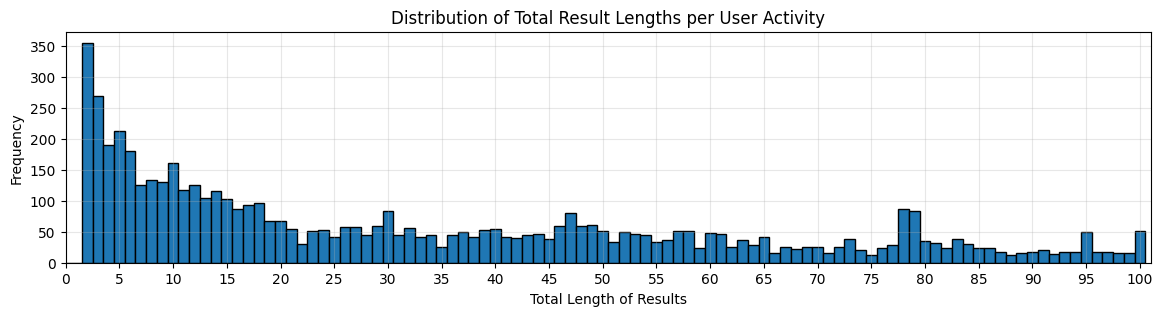

In [129]:
# Compute lengths of results per activity
result_lengths = [len(ua.results) for ua in user_activities]
xlim = 100

# Plot histogram
plt.figure(figsize=(14, 3))
plt.hist(result_lengths, bins=range(xlim + 2), edgecolor='black', align='left')
plt.xlim(0, xlim + 1)
plt.xlabel('Total Length of Results')
plt.ylabel('Frequency')
plt.title('Distribution of Total Result Lengths per User Activity')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, xlim + 1, max(1, xlim // 20)))

plt.show()

In [133]:
num_users = len(set(ua.issuer for ua in user_activities))
num_queries = len(list(ua.query for ua in user_activities))
print(f"Number of users: {num_users}")
print(f"Number of queries: {num_queries}")

Total number of activities: 7689
Number of users: 821
Number of queries: 7689


# Chosen Ranking Positions

769
769


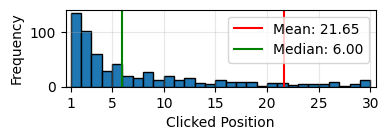

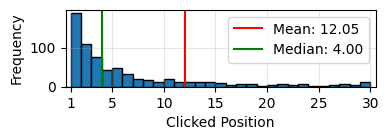

In [41]:
def plot_chosen_indices(ranking_algo):
    with open(f'results/reranked_activities/{ranking_algo}.pkl', 'rb') as f:
        user_activities = pickle.load(f)
        print(len(user_activities))
        
    chosen_indices = []
    for ua in user_activities:
        if ua.chosen_result is None:
            continue
        try:
            chosen_idx = next(i for i, r in enumerate(ua.results) if r.infohash == ua.chosen_result.infohash) + 1
            chosen_indices.append(chosen_idx)
        except StopIteration:
            # Skip if the chosen result isn't found in results list
            continue

    avg_chosen_index = np.mean(chosen_indices)
    median_chosen_index = np.median(chosen_indices)

    plt.figure(figsize=(4, 1))
    xlimit = 30
    plt.hist([x for x in chosen_indices if x <= xlimit], bins=range(xlimit+1), edgecolor='black')
    plt.axvline(avg_chosen_index, color='red', linestyle='-', label=f'Mean: {avg_chosen_index:.2f}')
    plt.axvline(median_chosen_index, color='green', linestyle='-', label=f'Median: {median_chosen_index:.2f}')
    plt.xlabel('Clicked Position')
    plt.ylabel('Frequency')
    # plt.yscale('log')
    plt.xlim(1, None)
    plt.xlim(0.5, xlimit+0.5)
    plt.xticks([1] + list(range(5, xlimit+1, 5)))
    plt.legend()
    plt.grid(True, alpha=0.3)
    tikzplotlib_fix_ncols(plt)
    tikzplotlib.save(
        f"results/tex/chosen_indices_{ranking_algo.lower()}.tex",
        axis_width=r'\columnwidth',
        axis_height=r'4cm')
    
plot_chosen_indices('tribler')
plot_chosen_indices('ltr')

# Performance with Context Size

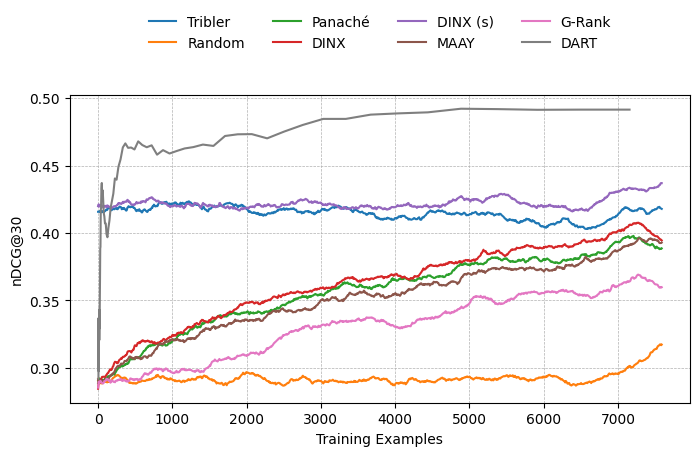

In [178]:
import matplotlib.pyplot as plt
import tikzplotlib
import numpy as np
import pickle

with open('results/context_ndcgs.pkl', 'rb') as f:
    all_ndcgs = pickle.load(f)

with open('results/context_ndcgs_ltr.pkl', 'rb') as f:
    all_ndcgs.update(pickle.load(f))

desired_k = 30
filtered_ndcgs = {}
for algo_name, index_dict in all_ndcgs.items():
    filtered_ndcgs[algo_name] = {x: metrics[desired_k] for x, metrics in index_dict.items() if desired_k in metrics}

all_ndcgs = filtered_ndcgs

def simple_moving_average(data, window_size):
    """Apply simple moving average with a fixed window size, ensuring length consistency."""
    if len(data) < window_size:
        return np.array(data)  # Return original if not enough data points
    smoothed = np.convolve(data, np.ones(window_size) / window_size, mode='valid')
    
    # Pad to maintain original length
    pad_size = (len(data) - len(smoothed)) // 2
    smoothed = np.pad(smoothed, (pad_size, len(data) - len(smoothed) - pad_size), mode='edge')
    
    return smoothed

def log_adaptive_moving_average(data, x, min_window, max_window):
    """Apply adaptive smoothing where the window size decreases logarithmically with x."""
    smoothed_data = []
    x_min = x[0] if x[0] != 0 else 1e-10  # Avoid division by zero
    
    for i in range(len(data)):
        log_x = np.log1p(x[i] - x_min)
        max_log_x = np.log1p(x[-1] - x_min)
        
        # Flip the scaling
        window_size = int(max_window - (max_window - min_window) * (log_x / max_log_x))
        window_size = max(1, window_size)  # Ensure at least a window size of 1
        
        start_idx = max(0, i - window_size // 2)
        end_idx = min(len(data), i + window_size // 2)
        smoothed_data.append(np.mean(data[start_idx:end_idx]))
    
    return np.array(smoothed_data)

def downsample_data(x, y, num_points=1000):
    """Downsample (x, y) to at most `num_points` points while preserving trends."""
    if len(x) <= num_points:
        return x, y  # No need to downsample

    indices = np.round(np.linspace(0, len(x) - 1, num_points)).astype(int)
    return [x[i] for i in indices], [y[i] for i in indices]


fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot all algorithms on the same axis
for algo_name, index_dict in all_ndcgs.items():
    x_filtered = sorted(index_dict.keys())
    y_vals = [index_dict[x] for x in x_filtered]
    
    if "ltr" in algo_name.lower():
        smoothed_vals = log_adaptive_moving_average(y_vals, x_filtered, 20, 2)
    else:
        # smoothed_vals = simple_moving_average(y_vals, 300)
        smoothed_vals = log_adaptive_moving_average(y_vals, x_filtered, 300, 100)
    
    x_downsampled, y_downsampled = downsample_data(x_filtered, smoothed_vals, num_points=1000)
    ax1.plot(x_downsampled, y_downsampled, label=ALGORITHMS[algo_name])

ax1.set_xlabel('Training Examples')
ax1.set_ylabel(f'nDCG@{desired_k or "max"}')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Combine legends
ax1.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.3),
    ncol=4,
    frameon=False
)

tikzplotlib_fix_ncols(plt)
tikzplotlib.save("results/tex/context_ndcgs.tex", axis_width=r'\columnwidth', axis_height=r'6cm')

plt.show()


In [152]:
all_ndcgs['ltr']

{5: 0.292,
 6: 0.381,
 7: 0.218,
 8: 0.311,
 9: 0.366,
 10: 0.295,
 12: 0.377,
 14: 0.265,
 16: 0.305,
 18: 0.452,
 20: 0.23,
 23: 0.395,
 26: 0.329,
 29: 0.379,
 32: 0.357,
 36: 0.482,
 40: 0.485,
 45: 0.461,
 50: 0.45,
 56: 0.403,
 62: 0.448,
 69: 0.411,
 76: 0.401,
 84: 0.355,
 93: 0.421,
 103: 0.407,
 114: 0.392,
 126: 0.437,
 139: 0.397,
 153: 0.403,
 169: 0.367,
 186: 0.389,
 205: 0.471,
 226: 0.473,
 249: 0.399,
 274: 0.468,
 302: 0.481,
 333: 0.473,
 367: 0.528,
 404: 0.426,
 445: 0.512,
 490: 0.468,
 540: 0.474,
 595: 0.425,
 655: 0.481,
 721: 0.406,
 794: 0.474,
 874: 0.453,
 962: 0.483,
 1059: 0.43,
 1165: 0.458,
 1282: 0.493,
 1411: 0.431,
 1553: 0.473,
 1709: 0.477,
 1880: 0.452,
 2069: 0.496,
 2276: 0.498,
 2504: 0.49,
 2755: 0.455,
 3031: 0.465,
 3335: 0.524,
 3669: 0.494,
 4036: 0.455,
 4440: 0.433,
 4885: 0.51,
 5374: 0.526,
 5912: 0.513,
 6504: 0.539,
 7155: 0.493}

In [39]:
len(all_ndcgs['ltr'])# First, ensure that the three algorithms exist in your results
for algo in ['ltr', 'Tribler', 'DINX (s)']:
    if algo not in all_ndcgs:
        raise ValueError(f"Algorithm '{algo}' is not in your data!")

# Get the set of training sample counts common to all three algorithms.
common_x = sorted(
    set(all_ndcgs['ltr'].keys()) &
    set(all_ndcgs['Tribler'].keys()) &
    set(all_ndcgs['DINX (s)'].keys())
)

# Extract the corresponding nDCG values for each algorithm.
ltr_ndcg      = np.array([all_ndcgs['ltr'][x] for x in common_x])
tribler_ndcg  = np.array([all_ndcgs['Tribler'][x] for x in common_x])
dinx_s_ndcg   = np.array([all_ndcgs['DINX (s)'][x] for x in common_x])

# Option 1: Check the raw (unsmoothed) data for the crossover point.
crossover_found = False
for x, ltr_val, trib_val, dinx_val in zip(common_x, ltr_ndcg, tribler_ndcg, dinx_s_ndcg):
    if ltr_val > trib_val and ltr_val > dinx_val:
        print(f"Raw Data: ltr overtakes tribler and dinx_s at {x} training examples.")
        print(f"nDCG@{desired_k}: ltr = {ltr_val:.3f}, tribler = {trib_val:.3f}, dinx_s = {dinx_val:.3f}")
        crossover_found = True
        break

if not crossover_found:
    print("In the raw data, ltr did not overtake both tribler and dinx_s.")

# Option 2: If you want to check the smoothed curves,
# you can apply your smoothing function to each algorithm’s data.
def get_smoothed_values(algo_key, min_window=min_window_size, max_window=max_window_size):
    # Get sorted x values and corresponding y values
    x_vals = sorted(all_ndcgs[algo_key].keys())
    y_vals = [all_ndcgs[algo_key][x] for x in x_vals]
    return x_vals, log_adaptive_moving_average(y_vals, x_vals, min_window, max_window)

# Retrieve smoothed curves.
x_ltr, ltr_smoothed       = get_smoothed_values('ltr')
x_tribler, tribler_smoothed = get_smoothed_values('Tribler')
x_dinx, dinx_smoothed     = get_smoothed_values('DINX (s)')

# For simplicity, assume that the x-values are (approximately) the same.
# (If not, you might need to interpolate the smoothed values to common x positions.)
min_length = min(len(x_ltr), len(x_tribler), len(x_dinx))
x_common = x_ltr[:min_length]
ltr_s = ltr_smoothed[:min_length]
tribler_s = tribler_smoothed[:min_length]
dinx_s = dinx_smoothed[:min_length]

crossover_found_smoothed = False
for x, ltr_val, trib_val, dinx_val in zip(x_common, ltr_s, tribler_s, dinx_s):
    if ltr_val > trib_val and ltr_val > dinx_val:
        print(f"Smoothed Data: ltr overtakes tribler and dinx_s at {x} training examples.")
        print(f"Smoothed nDCG@{desired_k}: ltr = {ltr_val:.3f}, tribler = {trib_val:.3f}, dinx_s = {dinx_val:.3f}")
        crossover_found_smoothed = True
        break

if not crossover_found_smoothed:
    print("In the smoothed data, ltr did not overtake both tribler and dinx_s.")


Raw Data: ltr overtakes tribler and dinx_s at 26 training examples.
nDCG@30: ltr = 0.434, tribler = 0.415, dinx_s = 0.372
Smoothed Data: ltr overtakes tribler and dinx_s at 186 training examples.
Smoothed nDCG@30: ltr = 0.424, tribler = 0.419, dinx_s = 0.418


# Decentralized Setting

Number of users:  101


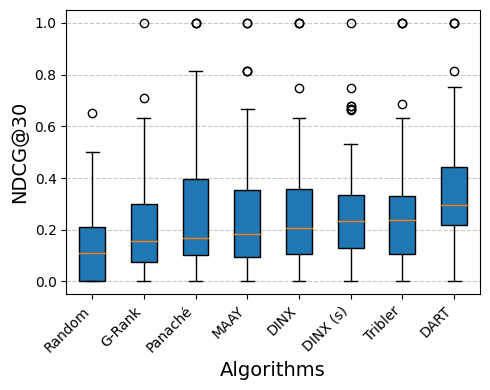

In [148]:
import json
import matplotlib.pyplot as plt
import tikzplotlib
from statistics import median

k = "30"

with open("results/p2p.json", "r") as f:
    data = json.load(f)

print("Number of users: ", len(data['tribler']))

ndcg_data = {}
for algorithm, algorithm_name in ALGORITHMS.items():
    if algorithm not in data:
        print(f"Warning: '{algorithm}' not found in the data. Skipping.")
        continue  # Skip to the next algorithm if not found
    items = data[algorithm]
    ndcg_values = [item['ndcg'].get(k) for item in items if 'ndcg' in item and item['ndcg'].get(k) is not None]
    ndcg_data[algorithm] = ndcg_values

# Order algorithms by median NDCG in ascending order
ordered_algorithms = sorted(ndcg_data.keys(), key=lambda algo: median(ndcg_data[algo]) if ndcg_data[algo] else float('inf'))
data_to_plot = [ndcg_data.get(algo, []) for algo in ordered_algorithms]

plt.figure(figsize=(5, 4))
plt.boxplot(data_to_plot, patch_artist=True)

plt.xticks([i + 1 for i in range(len(ordered_algorithms))], [ALGORITHMS[algo] for algo in ordered_algorithms], rotation=45, ha='right')
plt.ylabel(f'NDCG@{k}', fontsize=14)
plt.xlabel('Algorithms', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
tikzplotlib_fix_ncols(plt)
tikzplotlib.save("results/tex/p2p_ndcg.tex", axis_width=r'\columnwidth', axis_height=r'6cm')
